In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from scipy.special import softmax
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

data_path = "News_Category_Dataset_v3.json"

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
raw_news = load_dataset("json", data_files=data_path, split="train")

print(raw_news[0])


{'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9', 'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters', 'category': 'U.S. NEWS', 'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.', 'authors': 'Carla K. Johnson, AP', 'date': datetime.datetime(2022, 9, 23, 0, 0)}


In [ ]:
categories = sorted(set(raw_news["category"]))
label2id = {c: i for i, c in enumerate(categories)}
id2label = {i: c for c, i in label2id.items()}

num_labels = len(categories)
print("Number of labels:", num_labels)
print("Example label mapping:", list(label2id.items())[:10])


Number of labels: 42
Example label mapping: [('ARTS', 0), ('ARTS & CULTURE', 1), ('BLACK VOICES', 2), ('BUSINESS', 3), ('COLLEGE', 4), ('COMEDY', 5), ('CRIME', 6), ('CULTURE & ARTS', 7), ('DIVORCE', 8), ('EDUCATION', 9)]


In [ ]:
def add_text_and_label(example):
    text = example["headline"]
    if example["short_description"]:
        text = text + "; " + example["short_description"]
    return {
        "text": text,
        "label": label2id[example["category"]],
    }

news_dataset = raw_news.map(
    add_text_and_label,
    remove_columns=["headline", "short_description", "category", "authors", "link", "date"],
)

print(news_dataset[0])


{'text': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters; Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.', 'label': 35}


In [ ]:
news_train_test = news_dataset.train_test_split(test_size=0.2, seed=42)

temp = news_train_test["train"].train_test_split(test_size=0.125, seed=42)

news_splits = {
    "train": temp["train"],  
    "validation": temp["test"], 
    "test": news_train_test["test"], 
}

for split_name, ds in news_splits.items():
    print(split_name, len(ds))


train 146668
validation 20953
test 41906


In [ ]:
max_length = 128

def tokenize_news(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )

tokenized_news = {}
for split in ["train", "validation", "test"]:
    tokenized_news[split] = news_splits[split].map(
        tokenize_news,
        batched=True,
        remove_columns=["text"], 
    )

print(tokenized_news["train"][0])


Map: 100%|██████████| 20953/20953 [00:01<00:00, 14124.78 examples/s]

{'label': 39, 'input_ids': [101, 2129, 1996, 2801, 1997, 1005, 18856, 19516, 1005, 3480, 4639, 2308, 1025, 1999, 1996, 2117, 2161, 1997, 1000, 13761, 2611, 1010, 1000, 4907, 15462, 1010, 1037, 7591, 6566, 3076, 2013, 6613, 1010, 4740, 1037, 18415, 1997, 11901, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
model_news = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

def compute_metrics_multiclass(eval_pred):
    logits, labels = eval_pred  
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )

    return {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
    }


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args_news = TrainingArguments(
    output_dir="./news-distilbert",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer_news = Trainer(
    model=model_news,
    args=training_args_news,
    train_dataset=tokenized_news["train"],
    eval_dataset=tokenized_news["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_multiclass,
)


/var/folders/hl/c7pd8_zd1qq_vz2203gnpk0m0000gn/T/ipykernel_51893/3389859227.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_news = Trainer(


In [19]:
trainer_news.train()

val_metrics_news = trainer_news.evaluate(tokenized_news["validation"])
print("Validation metrics (News):", val_metrics_news)

test_metrics_news = trainer_news.evaluate(tokenized_news["test"])
print("Test metrics (News):", test_metrics_news)


/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,2.368100
1000,1.642000
1500,1.430400
2000,1.335800
2500,1.258800
3000,1.228000
3500,1.185500
4000,1.148600
4500,1.114800
5000,1.002800


/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation metrics (News): {'eval_loss': 1.0131875276565552, 'eval_accuracy': 0.7078699947501551, 'eval_precision_macro': 0.6316621118636961, 'eval_recall_macro': 0.5938505520787821, 'eval_f1_macro': 0.6083178799623644, 'eval_runtime': 78.2183, 'eval_samples_per_second': 267.878, 'eval_steps_per_second': 4.193, 'epoch': 3.0}


/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics (News): {'eval_loss': 1.0136009454727173, 'eval_accuracy': 0.7040280628072353, 'eval_precision_macro': 0.6275233808508894, 'eval_recall_macro': 0.5894309260697317, 'eval_f1_macro': 0.6040061319600805, 'eval_runtime': 154.1198, 'eval_samples_per_second': 271.905, 'eval_steps_per_second': 4.25, 'epoch': 3.0}


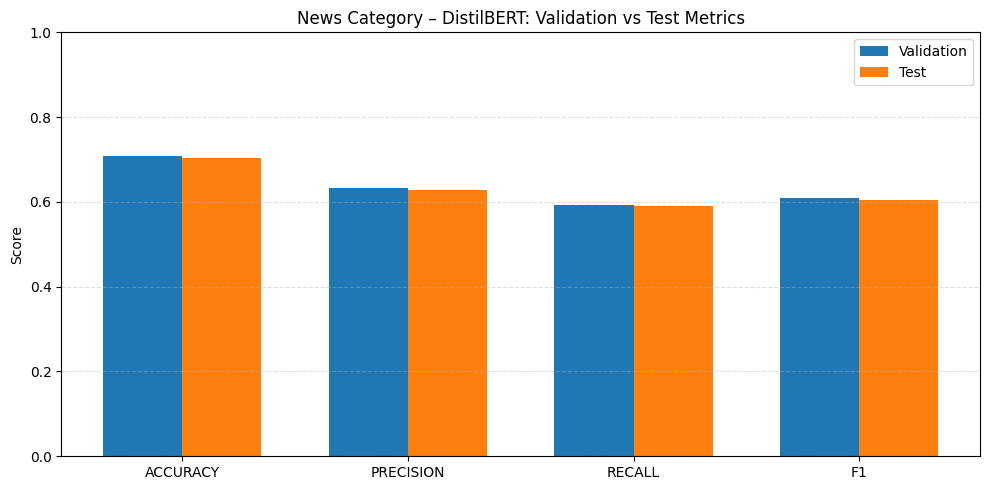

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metric_names = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

val_values = [val_metrics_news[f"eval_{m}"] for m in metric_names]
test_values = [test_metrics_news[f"eval_{m}"] for m in metric_names]

x = np.arange(len(metric_names))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, val_values, width, label="Validation")
plt.bar(x + width/2, test_values, width, label="Test")

plt.xticks(x, [m.replace("_macro", "").upper() for m in metric_names])
plt.ylabel("Score")
plt.title("News Category – DistilBERT: Validation vs Test Metrics")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


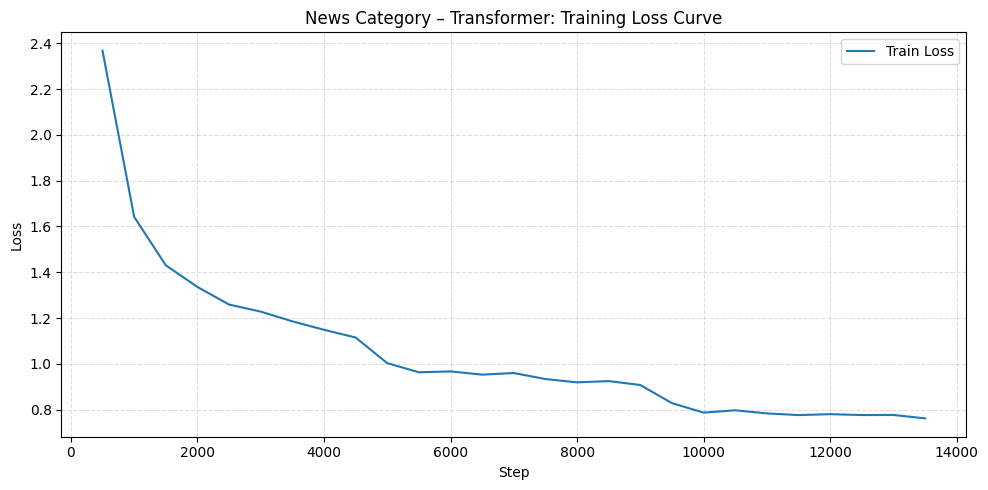

In [ ]:
log_history = trainer_news.state.log_history

train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_steps.append(log["step"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_loss.append(log["eval_loss"])

plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Train Loss")
# if eval_steps:
#     plt.plot(eval_steps, eval_loss, label="Validation Loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("News Category – Transformer: Training Loss Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


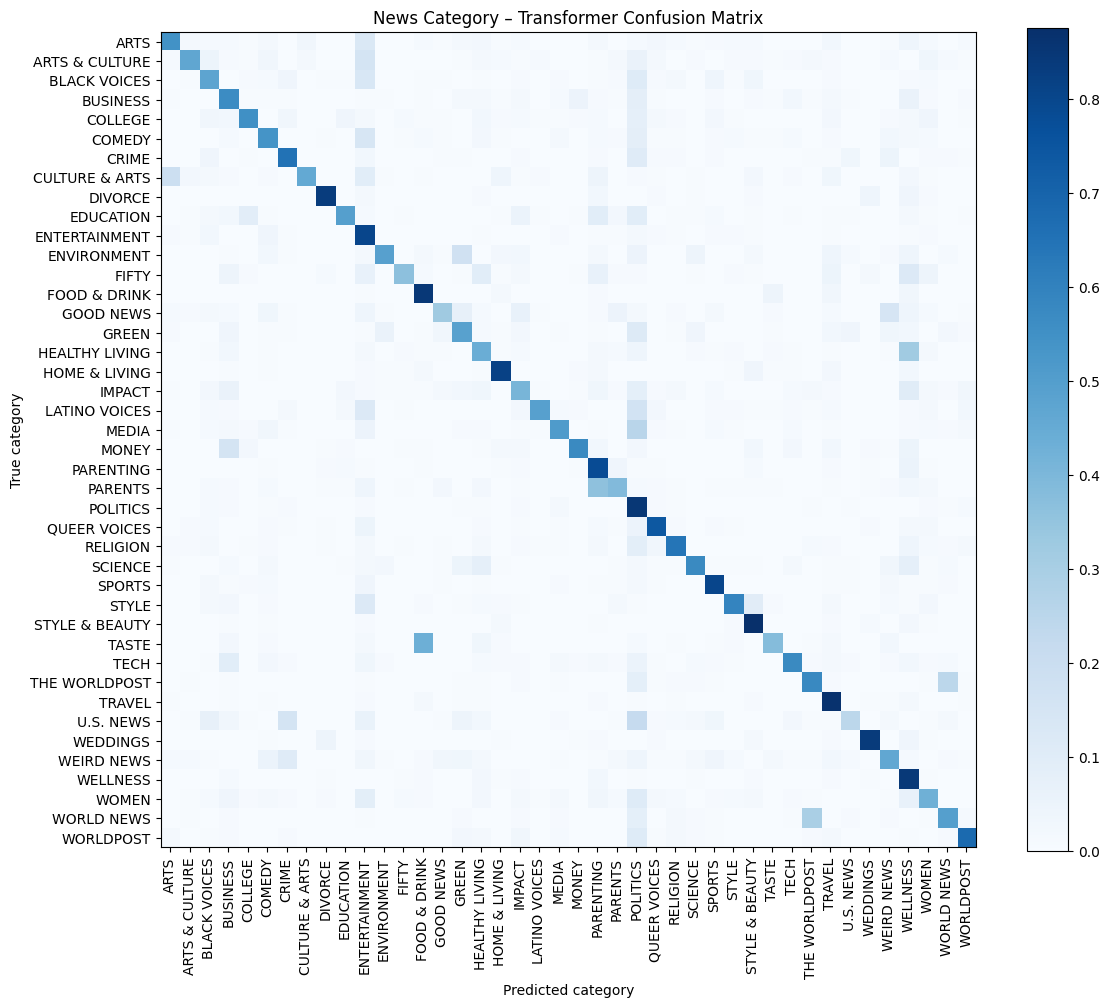

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

news_pred_output = trainer_news.predict(tokenized_news["test"])
logits_news = news_pred_output.predictions
y_true_news = news_pred_output.label_ids

y_pred_news = np.argmax(logits_news, axis=-1)

cm_news = confusion_matrix(y_true_news, y_pred_news, normalize='true')

class_names = [id2label[i] for i in range(len(id2label))]

plt.figure(figsize=(12, 10))
disp_news = ConfusionMatrixDisplay(confusion_matrix=cm_news, display_labels=class_names)
disp_news.plot(include_values=False, xticks_rotation='vertical',cmap="Blues",ax=plt.gca())

plt.title("News Category – Transformer Confusion Matrix")
plt.xlabel("Predicted category")
plt.ylabel("True category")
plt.tight_layout()
plt.show()
